# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [9]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

## 2. Load Simulated Data

In [10]:
# File path
npz_file_path = os.path.join("./data", "padded_simulated_data_petsc.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print(f"Successfully loaded arrays and config from {npz_file_path}.")

Successfully loaded arrays and config from ./data/padded_simulated_data_petsc.npz.


In [ ]:
# Reduce Stepsize px
step_size_px = 10
points_per_wavelength = 2
empty_space_px = 0

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
    empty_space_px=empty_space_px,
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-14 22:22:14,030 - INFO - === Scan Summary ===
2025-12-14 22:22:14,034 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 22:22:14,035 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-14 22:22:14,036 - INFO -   Sample Pixels:          750 px
2025-12-14 22:22:14,038 - INFO -   Step size:              5 px
2025-12-14 22:22:14,042 - INFO -   Number of scan points:  60
2025-12-14 22:22:14,043 - INFO -   Steps in z:             472
2025-12-14 22:22:14,044 - INFO -   Solve reduced domain:   454 px
2025-12-14 22:22:14,045 - INFO -   Max Overlap Pixels:     450 px
2025-12-14 22:22:14,046 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 22:22:14,047 - INFO -   Probe Pixels:           49 px
2025-12-14 22:22:14,048 - INFO -   Max Overlap:            8.999e-06 m
2025-12-14 22:22:14,049 - INFO -   Percentage Overlap:     89.99%



Reduce Stepsize px: 40 -> 5
Points per wavelength: 12 -> 4


## 3. Reduce Data Dimensionality

In [12]:
# Remove Empty Space Padding from ref_index
print("Cropping empty space from ref_index and exit_waves...")

print(f"original shape:{exit_waves.shape}")
if loaded_sim_config["empty_space_px"] > empty_space_px:
    crop_px = loaded_sim_config["empty_space_px"] - empty_space_px
else:
    crop_px = loaded_sim_config["empty_space_px"]
print(
    f"Remove px: {crop_px} pixels on each side."
)
data_ew_cropped = exit_waves[
    :,
    crop_px:-crop_px,
]
print(f"cropped shape:{data_ew_cropped.shape}")

Cropping empty space from ref_index and exit_waves...
original shape:(60, 7640)
Remove px: 2000 pixels on each side.
cropped shape:(60, 3640)


Original exit waves shape: (60, 3640)
Coarse exit waves shape: (60, 454)


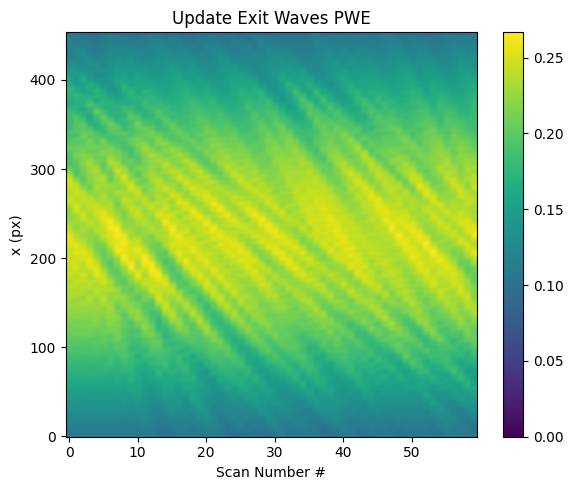

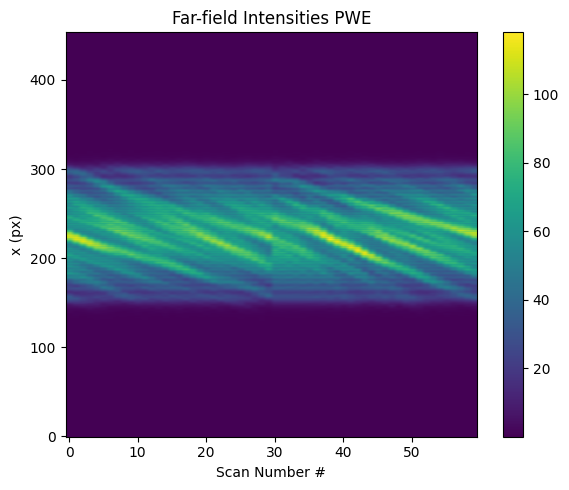

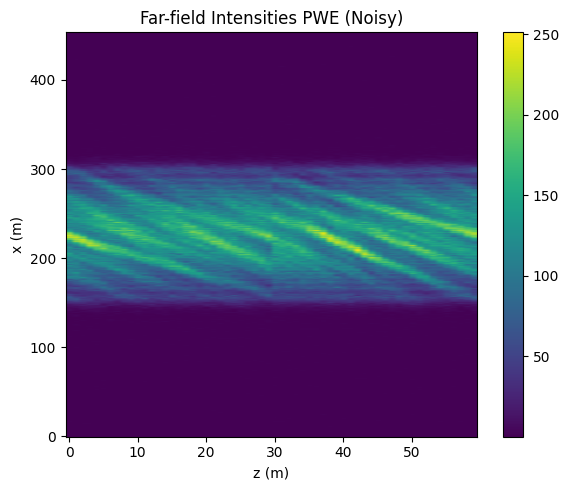

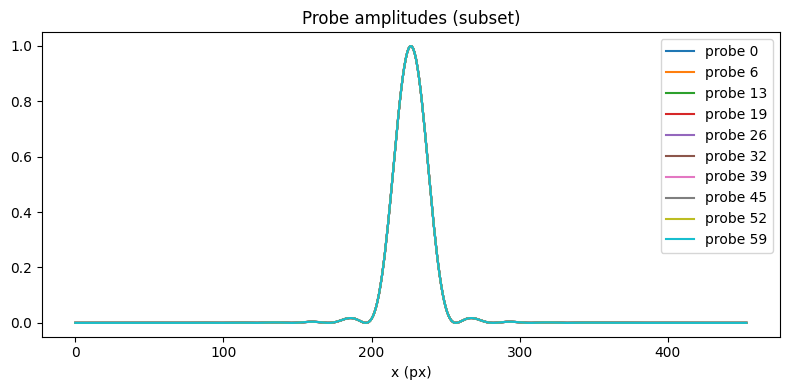

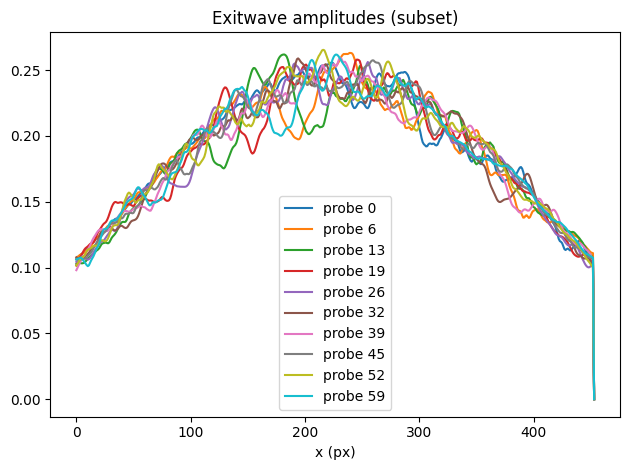

In [13]:
# Reduce Pixel Size by Zooming Exit Waves
original_shape = data_ew_cropped.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data_ew = zoom(data_ew_cropped, zoom_factors, order=1)
data = np.abs(np.fft.fft(data_ew)) ** 2

print(f"Original exit waves shape: {data_ew_cropped.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

Original ref_index shape: (6001, 1417)


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Original Refractive Index Phase'}, xlabel='z (px)', ylabel='x (px)'>,
        <Axes: title={'center': 'Original Refractive Index Amplitude'}, xlabel='z (px)', ylabel='x (px)'>],
       dtype=object))

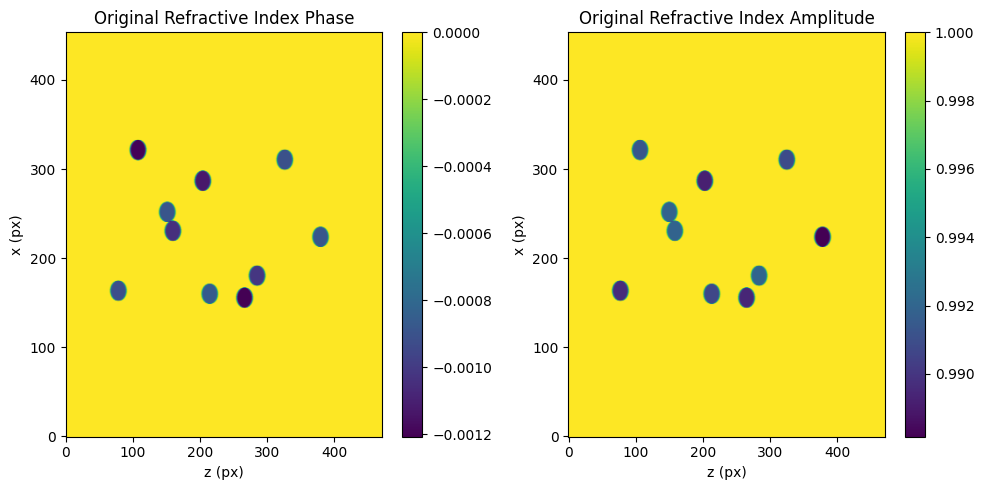

In [14]:

# Original Refactive Index Shap
ref_index_shape = ref_index.shape
print(f"Original ref_index shape: {ref_index_shape}")
target_shape = (simulation_space.effective_nx, simulation_space.nz)
zoom_factors = np.array(target_shape) / np.array(ref_index_shape)
ref_index_zoomed = zoom(ref_index, zoom_factors)
simulation_space.viewer.plot_two_panels(
    ref_index_zoomed,  # Use ifftshift to move zero frequency to the corner
    title="Original Refractive Index",
    xlabel="z (px)",
    ylabel="x (px)",
)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [ ]:
recon_ms = ReconstructorMS(
    simulation_space, data, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

2025-12-14 22:22:16,126 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-14 22:22:20,148 - INFO - [Iter 001] Mean Loss = 0.174046, Time = 4.02 seconds
2025-12-14 22:22:24,237 - INFO - [Iter 002] Mean Loss = 0.154638, Time = 4.09 seconds
2025-12-14 22:22:33,478 - INFO - [Iter 003] Mean Loss = 0.151423, Time = 9.24 seconds
2025-12-14 22:22:37,720 - INFO - [Iter 004] Mean Loss = 0.150205, Time = 4.24 seconds
2025-12-14 22:22:41,759 - INFO - [Iter 005] Mean Loss = 0.149516, Time = 4.04 seconds
2025-12-14 22:22:45,583 - INFO - [Iter 006] Mean Loss = 0.149025, Time = 3.82 seconds
2025-12-14 22:22:49,804 - INFO - [Iter 007] Mean Loss = 0.148627, Time = 4.22 seconds
2025-12-14 22:22:53,635 - INFO - [Iter 008] Mean Loss = 0.148283, Time = 3.83 seconds
2025-12-14 22:22:56,650 - INFO - [Iter 009] Mean Loss = 0.147978, Time = 3.01 seconds
2025-12-14 22:22:59,666 - INFO - [Iter 010] Mean Loss = 0.147702, Time = 3.02 seconds
2025-12-14 22:23:05,765 - INFO - [Iter 011] Mean Loss = 0.147451

Abort is in progress...hit ctrl-c again within 5 seconds to forcibly terminate



KeyboardInterrupt: 

In [ ]:
atol = 1e-4
alpha = 1e-8
recon_pwe = ReconstructorPWE(
    simulation_space, data, phase_retrieval=True, verbose=True, 
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, u, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:171: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype))
/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:184: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((A_bar_H - (z_conj * B_bar_H)).astype(self.dtype))
2025-12-14 22:12:25,551 - INFO - Initializing Least Squares Solver...
2025-12-14 22:12:25,591 - INFO - Iteration 1/30
2025-12-14 22:12:40,542 - INFO -     RMSE: 0.12129554873767893
2025-12-14 22:13:10,444 - INFO -     Iteration 1 took 44.85 seconds.
2025-12-14 22:13:10,448 - INFO - Iteration 2/30
2025-12-14 22:13:34,319 - INFO -     RMSE: 0.11370196646830366
2025-12-14 22:14:59,016 - INFO -     Iteration 2 took 108.57 seconds.
2025-12-14 22:14:59,017 - INFO - Iteration 3/30
2025-12-14 22:15:24,566 - INFO -     RMSE: 0.1093733843830669
2025-12-14 22:17:0

KeyboardInterrupt: 